In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from keijzer_exogan import *

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

#%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
#sns.set()

Random Seed:  999


In [2]:
torch.cuda.device_count()

1

In [3]:
# Root directory for dataset
dataroot = "/datc/opschaler/brian/celeba_complete"

# Number of workers for dataloader
workers = 0 # 0 when to_vram is enabled

# Batch size during training
batch_size = 128 # 2**11
print('Batch size: ', batch_size)

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs =1*10**3

# Learning rate for optimizers
lr = 2e-4
lr_G = 2e-4

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
selected_gpus = [0]
ngpu = len(selected_gpus)

Batch size:  128


## Mark the below cell as code to use the celeba dataset

## Mark the below cell as code to use the ExoGAN dataset

In [4]:
pwd

'F:\\Jupyterlab\\SRON-DCGAN\\notebooks'

In [5]:
##### Creating custom Dataset classes
path = 'F:\Jupyterlab\SRON-DCGAN\data\\' #notice how you dont put the last folder in here...
images = np.load(path+'first_chunks_25_percent_images.npy')

shuffle = True

if shuffle:
    np.random.shuffle(images) # shuffles the images

images = images[:int(len(images)*0.05)] # use only first ... percent of the data (0.05)
print('Number of images: ', len(images))

dataset = numpy_dataset(data=images, to_vram=False) # to_vram pins it to all GPU's
#dataset = numpy_dataset(data=images, to_vram=True, transform=transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])) # to_vram pins it to all GPU's

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=False)

Number of images:  25000


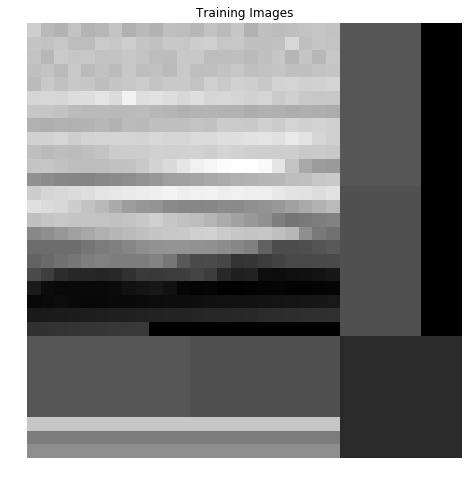

In [6]:
# Decide which device we want to run on
# Seems to be the main devive, e.g. cuda:0 wont work when only gpu [2,3] are selected... is [2,3] then do cuda:2
device = torch.device("cuda:"+str(selected_gpus[0]) if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        """
        where (in_channels, out_channels, 
        kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1)
        """
        self.main = nn.Sequential(
            
            #1
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            #4
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.Dropout2d(0.5),
            
            #7
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Dropout2d(0.5),
            
            #10
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf*1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*1),
            nn.ReLU(True),
            
            # Go from 1x64x64 to 1x32x32
            nn.Conv2d(ngf, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*1),
            nn.ReLU(True),
                        #10
            # state size. (ngf*2) x 16 x 16
            #nn.ConvTranspose2d( ngf * 2, ngf*1, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ngf*1),
            #nn.ReLU(True),
            
            #13
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf*1, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, device_ids=selected_gpus, output_device=device) # select only gpu 0, 2, 3

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): Dropout2d(p=0.5)
    (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Dropout2d(p=0.5)
    (11): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)


In [10]:
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): Dropout2d(p=0.5)
    (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Dropout2d(p=0.5)
    (11): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)


In [11]:
from torchsummary import summary

noise = torch.randn(batch_size, nz, 1, 1, device=device)
noise.shape
summary(netG, (100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         409,600
       BatchNorm2d-2            [-1, 256, 4, 4]             512
              ReLU-3            [-1, 256, 4, 4]               0
   ConvTranspose2d-4            [-1, 128, 8, 8]         524,288
       BatchNorm2d-5            [-1, 128, 8, 8]             256
              ReLU-6            [-1, 128, 8, 8]               0
         Dropout2d-7            [-1, 128, 8, 8]               0
   ConvTranspose2d-8           [-1, 64, 16, 16]         131,072
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
        Dropout2d-11           [-1, 64, 16, 16]               0
  ConvTranspose2d-12           [-1, 32, 32, 32]          32,768
      BatchNorm2d-13           [-1, 32, 32, 32]              64
             ReLU-14           [-1, 32,

In [12]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 1, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 1, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [13]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    print('netD to cuda')
    netD = nn.DataParallel(netD, device_ids=selected_gpus, output_device=device) # select only gpu 0, 2, 3

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace)
    (7): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace)
    (10): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2, inplace)
    (13): Conv

In [15]:
from torchsummary import summary
summary(netD, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             512
         LeakyReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]          16,384
         LeakyReLU-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 4, 4]          32,768
       BatchNorm2d-6             [-1, 64, 4, 4]             128
         LeakyReLU-7             [-1, 64, 4, 4]               0
            Conv2d-8            [-1, 128, 2, 2]         131,072
       BatchNorm2d-9            [-1, 128, 2, 2]             256
        LeakyReLU-10            [-1, 128, 2, 2]               0
           Conv2d-11            [-1, 256, 1, 1]         524,288
      BatchNorm2d-12            [-1, 256, 1, 1]             512
        LeakyReLU-13            [-1, 256, 1, 1]               0
           Conv2d-14              [-1, 

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)) # should be sgd
optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999))

In [ ]:
import time as t

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

In [ ]:
train_D = True
train_G = True

In [ ]:
from IPython.display import clear_output

In [16]:
# Load saved weights
netG.load_state_dict(torch.load('netG_state_dict', map_location=device))) #net.module..load_... for parallel model , net.load_... for single gpu model
netD.load_state_dict(torch.load('netD_state_dict', map_location=device)))

AttributeError: 'Generator' object has no attribute 'module'

In [ ]:
iters = 0

t1 = t.time()
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    q = np.random.randint(3, 6)
    #q = 1000
    
    for i, data in enumerate(dataloader, 0):

        # Format batch

        #if i % 11: # show first image of the real dataset every ... iterations
        #    print('real:')
        #    plt.imshow(data[0, 0, :, :].reshape(32, 32))
        #    plt.show()
        
        # real_cpu = data.to(device) # for np array images
        real_cpu = data.to(device) # for PIL images
        b_size = real_cpu.size(0)

        """
        https://github.com/soumith/ganhacks
        implement random label range from 0.0-0.3 to 0.7-1.2 for fake and real respectively
        """
        low = 0.01
        high = 0.2 #0.3
        fake_label = (low - high) * torch.rand(1) + high # uniform random dist between low and high
        fake_label = fake_label.data[0] # Gets the variable out of the tensor

        low = 0.8 #0.7
        high = 1.0
        real_label = (low - high) * torch.rand(1) + high # uniform random dist between low and high
        real_label = real_label.data[0] # Gets the variable out of the tensor

        label = torch.full((b_size,), real_label, device=device)
        
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)


        if i % q == 0:
            labels_inverted = 'yes' 
            label.fill_(fake_label)
        else:
            labels_inverted = 'no'
            label.fill_(real_label)
        
        #if i > 1:
        #    if D_G_z1 < 0.45: # 45
        #        train_G = True
        #        train_D = False
        #    else:
        #        train_D = True
        #        train_G = False

        if train_D:
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            
        # Forward pass real batch through D
        print('real_cpu shape: ',real_cpu.shape)
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label) ## make this fake label sometimes
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)

        #if i % 11: # show first image of the real dataset every ... iterations
        #    print(fake.shape)
        #    plt.imshow(fake.reshape(32, 32))
        #    plt.show()
        
        # swap labels for the discriminator when i % q == 0 (so once every q-th batch)
        if i % q == 0:
            label.fill_(real_label)
        else:
            label.fill_(fake_label)

        #label.fill_(fake_label) ## make this real label sometimes
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        
        if train_D:
            optimizerD.step()
        
        if train_G:
            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        
        if train_G:
            # Update G
            optimizerG.step()
                
        t2 = t.time()
        # Output training stats
        
        if train_G and train_D:
            training_dg = 'D & G'
        elif train_G:
            training_dg = 'G'
        elif train_D:
            training_dg = '\t D'
        
        if iters % (1) == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\t Time: %.2f \t q: %s \t training: %s'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, (t2-t1), q, training_dg))
            t1 = t.time()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 13 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        #if (iters % 98 == 0):
        #    plt.imshow(np.transpose(fake[0],(1,2,0)))
        #    plt.show()

        iters += 1
        
    """
    Plot losses
    """
    clear_output() # clears cell output
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(D_losses,label="D")
    plt.plot(G_losses,label="G")
    plt.xlabel("iterations")
    plt.ylabel("Loss")

    plt.legend()
    plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.legend()
plt.show()

In [ ]:
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.ylim((0,1))
plt.legend()
plt.show()

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Ground truth image")
#plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Generated images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
#plt.tight_layout()
#plt.savefig('plots/DCGAN_generated.png', dpi=1200)
print('plt saved')

In [ ]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 20**128

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Impainting
working on implementing: https://github.com/lotuswhl/Image-inpainting-with-dcgan-pytorch